Version: 02.14.2023

# Lab 6.1: Implementing Topic Modeling with Amazon Comprehend

In this lab, you will use Amazon Comprehend to extract topics from the [20 Newsgroups](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) dataset.

## About this dataset

The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. This collection has become a popular dataset for experiments in text applications of machine learning techniques, such as text classification and text clustering. In this lab, you will see what topics you can learn from this set of documents using the Neural Topic Model (NTM) algorithm.

Dataset source: Tom Mitchell. *20 Newsgroups Data*. September 9, 1999. Distributed by UCI KDD Archive. https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html.


## Lab steps

To complete this lab, you will follow these steps:

1. [Importing requirements and creating session variables](#1.-Importing-requirements-and-creating-session-variables)
2. [Importing the newsgroup files](#2.-Importing-the-newsgroup-files)
3. [Examining and preprocessing the data](#3.-Examining-and-preprocessing-the-data)
4. [Analyzing the Amazon Comprehend Events output](#4.-Analyzing-the-Amazon-Comprehend-Events-output)


## Submitting your work

1. In the lab console, choose **Submit** to record your progress and when prompted, choose **Yes**.

1. If the results don't display after a couple of minutes, return to the top of these instructions and choose **Grades**.

     **Tip**: You can submit your work multiple times. After you change your work, choose **Submit** again. Your last submission is what will be recorded for this lab.

1. To find detailed feedback on your work, choose **Details** followed by **View Submission Report**.

## 1. Importing requirements and creating session variables
([Go to top](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))

In this section, you will update and install the packages that you will use in the notebook. You will also create the session variables. 


In [1]:
import boto3
import uuid
# Client and session information
comprehend_client = boto3.client(service_name='comprehend')


# Constants for the S3 bucket and input data file
bucket = 'c73485a1491093l3864415t1w678677911916-labbucket-2xfv1lh3t2fv'
data_access_role_arn = 'arn:aws:iam::678677911916:role/service-role/c73485a1491093l3864415t1w-ComprehendDataAccessRole-98Q9DUDVAXY8'
print("Cell execution completed")

Cell execution completed


## 2. Importing the newsgroup files
([Go to top](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))

Now define the folder to hold the data. Then, clean up the folder, which might contain data from previous experiments.

In [2]:
import os
import shutil

data_dir = '20_newsgroups'
if os.path.exists(data_dir):  # Clean up existing data folder
    shutil.rmtree(data_dir)
print("Cell execution completed")

Cell execution completed


The newsgroup documents are stored as individual files in a .tar file. 

In the next two cells, you unpack the dataset and extract a list of the files.

In [3]:
!tar -xzf ../s3/20_newsgroups.tar.gz
!ls 20_newsgroups
print("Cell execution completed")

alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med
Cell execution completed


In [4]:
folders = [os.path.join(data_dir,f) for f in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, f))]
file_list = [os.path.join(d,f) for d in folders for f in os.listdir(d)]
print('Number of documents:', len(file_list))

Number of documents: 19997


## 3. Examining and preprocessing the data
([Go to top](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))
    
In this section, you will examine the data and perform some standard natural language processing (NLP) data cleaning tasks.

In [5]:
!cat 20_newsgroups/comp.graphics/37917
print("Cell execution completed")

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!elroy.jpl.nasa.gov!nntp-server.caltech.edu!andrey
From: andrey@cco.caltech.edu (Andre T. Yew)
Newsgroups: comp.graphics
Subject: Re: 16 million vs 65 thousand colors
Date: 3 Apr 1993 19:51:06 GMT
Organization: California Institute of Technology, Pasadena
Lines: 28
Message-ID: <1pkpraINNck9@gap.caltech.edu>
References: <1993Mar26.210323.27802@midway.uchicago.edu> <dotzlaw-020493084300@murphy.biochem.umanitoba.ca> <d9hh.733845825@dtek.chalmers.se>
NNTP-Posting-Host: punisher.caltech.edu

d9hh@dtek.chalmers.se (Henrik Harmsen) writes:

>1-4 bits per R/G/B gives horrible machbanding visible in almost any picture.

>5 bits per R/G/B (32768, 65000 colors) gives visible machbanding

>color-gradient picture has _almost_ no machbanding. This color-resolution is 

>see some small machbanding on the smooth color-gradient picture, but all in all,
>There _ARE_ situiations where 

Each newsgroup document can have the following sections:
- header - Contains the standard newsgroup header information. This should be removed.
- quoted text - Text from a previous message, which usually is prefixed with '>' or '|', and sometimes starts with *writes*, *wrote*, *said*, or *says*.
- message - Body of the message that you want to extract topics from.
- footer - Messages typically end with a signature.

The following functions will remove the headers, quoted text, and footers.

In [6]:
# From sklearn.datasets.twenty_newsgroups import strip_newsgroup_header, strip_newsgroup_quoting, strip_newsgroup_footer
import re
def strip_newsgroup_header(text):
    """
    Given text in "news" format, strip the headers by removing everything
    before the first blank line.
    """
    _before, _blankline, after = text.partition('\n\n')
    return after

_QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                       r'|^In article|^Quoted from|^\||^>)')


def strip_newsgroup_quoting(text):
    """
    Given text in "news" format, strip lines beginning with the quote
    characters > or |, plus lines that often introduce a quoted section
    (for example, because they contain the string 'writes:'.)
    """
    good_lines = [line for line in text.split('\n')
                  if not _QUOTE_RE.search(line)]
    return '\n'.join(good_lines)


def strip_newsgroup_footer(text):
    """
    Given text in "news" format, attempt to remove a signature block.

    As a rough heuristic, we assume that signatures are set apart by either
    a blank line or a line made of hyphens, and that it is the last such line
    in the file (disregarding blank lines at the end).
    """
    lines = text.strip().split('\n')
    for line_num in range(len(lines) - 1, -1, -1):
        line = lines[line_num]
        if line.strip().strip('-') == '':
            break

    if line_num > 0:
        return '\n'.join(lines[:line_num])
    else:
        return text
print("Cell execution completed")

Cell execution completed


Now remove the headers, footers, and quotes to clean the data. Use the three functions that you just defined.

In [7]:
data = []
for f in file_list:
    with open(f, 'rb') as fin:
        content = fin.read().decode('latin1')   
        content = strip_newsgroup_header(content)
        content = strip_newsgroup_quoting(content)
        content = strip_newsgroup_footer(content)
        # remove header, quoting and footer
        data.append(content)
print("Cell execution completed")

Cell execution completed


Next, save all of the newsgroup documents to a single file, with one document on each line.

In [8]:
with open('comprehend_input.txt','w', encoding='UTF-8') as cf:
    for line in data:
        line = line.strip()
        line = re.sub('\n',' ',line)
        line = re.sub('\r',' ',line)
        cf.write(line+'\n')
print("Cell execution completed")

Cell execution completed


The data needs to be uploaded to an S3 bucket to be available to Amazon Comprehend. The following function uploads the data to Amazon S3.

In [9]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file('comprehend_input.txt', 'comprehend/newsgroups')
print("Cell execution completed")

Cell execution completed


In [10]:
number_of_topics = 20

input_s3_url = f"s3://{bucket}/comprehend"
input_doc_format = "ONE_DOC_PER_LINE"
input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}

output_s3_url = f"s3://{bucket}/outputfolder/"
output_data_config = {"S3Uri": output_s3_url}

job_uuid = uuid.uuid1()
job_name = f"top-job-{job_uuid}"

print(input_s3_url)
print("Cell execution completed")

s3://c73485a1491093l3864415t1w678677911916-labbucket-2xfv1lh3t2fv/comprehend
Cell execution completed


Now start the Amazon Comprehend topic detection job.

In [11]:
start_topics_detection_job_result = comprehend_client.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                                              InputDataConfig=input_data_config,
                                                                              JobName=job_name,
                                                                              OutputDataConfig=output_data_config,
                                                                              DataAccessRoleArn=data_access_role_arn
                                                                            )


print("Cell execution completed")

Cell execution completed


Get the job status and wait until the job is complete. This will take 25–35 minutes.

In [12]:
# Get current job status
from time import sleep
job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

# Loop until job is completed
waited = 0
timeout_minutes = 40
while job['TopicsDetectionJobProperties']['JobStatus'] != 'COMPLETED':
    sleep(60)
    waited += 60
    assert waited//60 < timeout_minutes, "Job timed out after %d seconds." % waited
    print('.', end='')
    job = comprehend_client.describe_topics_detection_job(JobId=start_topics_detection_job_result['JobId'])

print('Ready')
print("Cell execution completed")

..............................Ready
Cell execution completed


When the job is complete, download the results.

In [13]:
topic_comprehend_output_file = job['TopicsDetectionJobProperties']['OutputDataConfig']['S3Uri']
print(f'output filename: {topic_comprehend_output_file}')

topics_comprehend_bucket, topics_comprehend_key = topic_comprehend_output_file.replace("s3://", "").split("/", 1)
print(topics_comprehend_key)
s3r = boto3.resource('s3')
s3r.meta.client.download_file(topics_comprehend_bucket, topics_comprehend_key, 'output.tar.gz')
print("Cell execution completed")

output filename: s3://c73485a1491093l3864415t1w678677911916-labbucket-2xfv1lh3t2fv/outputfolder/678677911916-TOPICS-f36aea15a9d30b345404a0178e61d278/output/output.tar.gz
outputfolder/678677911916-TOPICS-f36aea15a9d30b345404a0178e61d278/output/output.tar.gz
Cell execution completed


In [14]:
# Extract the .tar file
import tarfile
tf = tarfile.open('output.tar.gz')
tf.extractall()
print("Cell execution completed")

Cell execution completed


## 4. Analyzing the Amazon Comprehend Events output
([Go to top](#Lab-6.1:-Implementing-Topic-Modeling-with-Amazon-Comprehend))



The compressed file that you downloaded from Amazon Comprehend contains two files:

- **topic-terms.csv** lists the topics in the collection. For each topic, the list includes the top 10 terms according to the weight.
- **doc-topics.csv** lists the documents that are associated with a topic and the proportion of the document that is concerned with the topic. Documents can be listed for more than one topic.

Load the topic-terms.csv file into a pandas DataFrame.

In [15]:
import pandas as pd
dftopicterms = pd.read_csv("topic-terms.csv")
print("Cell execution completed")

Cell execution completed


Review the first few rows.

In [21]:
dftopicterms.head()

,topic,term,weight
0,0,people,0.031250
1,0,thing,0.011662
2,0,government,0.009719
3,0,force,0.008121
4,0,kill,0.006174


Print each of the topics and the top words for each topic. 

In [17]:
# Selecting rows based on condition
for t in range(0,number_of_topics):
    rslt_df = dftopicterms.loc[dftopicterms['topic'] == t]
    topic_list = rslt_df['term'].values.tolist()
    print(f'Topic {t:2} - {topic_list}')
print("Cell execution completed")

Topic  0 - ['people', 'thing', 'government', 'force', 'kill', 'live', 'associate', 'gun', 'law', 'moral']
Topic  1 - ['find', 'source', 'information', 'stuff', 'code', 'delete', 'site', 'ftp', 'image', 'advance']
Topic  2 - ['year', 'team', 'ago', 'beat', 'win', 'player', 'play', 'game', 'league', 'season']
Topic  3 - ['work', 'bike', 'bite', 'machine', 'modem', 'suppose', 'port', 'universe', 'version', 'accurately']
Topic  4 - ['program', 'disk', 'read', 'run', 'mac', 'pc', 'book', 'write', 'speed', 'copy']
Topic  5 - ['christian', 'jesus', 'koresh', 'david', 'people', 'claim', 'church', 'christ', 'bible', 'religion']
Topic  6 - ['book', 'read', 'church', 'christian', 'randism', 'write', 'disk', 'jesus', 'article', 'bible']
Topic  7 - ['sell', 'price', 'offer', 'ship', 'include', 'pay', 'condition', 'email', 'buy', 'interest']
Topic  8 - ['post', 'day', 'article', 'read', 'delete', 'stuff', 'group', 'think', 'lot', 'reply']
Topic  9 - ['file', 'format', 'program', 'window', 'convert',

Note that the topics are not named. This is an exercise for a human to determine. 

Based on the words in the output for the previous cell, think of a word that describes each topic. In the following cell, replace the placeholder text with the words you have decided on to describe each topic.

In [18]:
colnames = pd.DataFrame({'topics':['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6','topic 7','topic 8','topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'topic 15', 'topic 16','topic 17','topic 18','topic 19']})
print("Cell execution completed")

Cell execution completed


Next, read in the doc-topics.csv file.

In [20]:
dfdoctopics = pd.read_csv("doc-topics.csv")
dfdoctopics.head()

,docname,topic,proportion
0,newsgroups:4,0,1.0
1,newsgroups:39,1,1.0
2,newsgroups:74,5,1.0
3,newsgroups:109,0,1.0
4,newsgroups:144,5,1.0


To make visualizations easier, select five articles to plot.

In [23]:
to_chart = dfdoctopics.loc[dfdoctopics['docname'].isin(['newsgroups:1000','newsgroups:2000','newsgroups:3000','newsgroups:4000','newsgroups:5000'])]
print("Cell execution completed")

Cell execution completed


Next, use the `pivot_table` function to map the values in the **docname** column to actual columns. This will make it easier to create a chart.

In [24]:
to_chart = to_chart.pivot_table(values='proportion', index='topic', columns='docname')
to_chart.head()
print("Cell execution completed")

Cell execution completed


Finally, plot the topics that belong to your newsgroup documents.

You will see that some documents have a single topic, while others contain a mixture. If you have too many topics, you can try to change the number of topics to get better results.

Cell execution completed


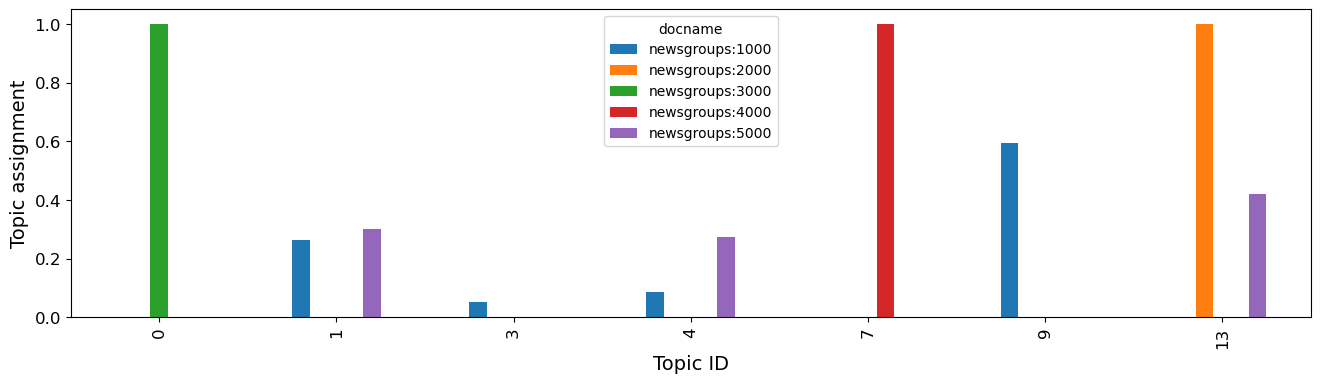

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
# df.index = colnames['topic']
to_chart.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)
print("Cell execution completed")

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

*©2023 Amazon Web Services, Inc. or its affiliates. All rights reserved. This work may not be reproduced or redistributed, in whole or in part, without prior written permission from Amazon Web Services, Inc. Commercial copying, lending, or selling is prohibited. All trademarks are the property of their owners.*
